## Automated EE stopping via tracking of KLD relative change

In [57]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE

# Pre-processing data 
sample = fk.Sample('data/flow18_annotated.fcs', sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]

In [58]:
fraction_used = 0.01

# sample from dataset 
data_sample = df_filtered.sample(frac=fraction_used).reset_index(drop=True)

# get features and labels 
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

In [59]:
len(features)

10000

In [72]:
# step 1: define affinities 
import openTSNE 
affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=50, 
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

# step 2: define initial embedding 
# init = openTSNE.initialization.pca(features.to_numpy(), random_state=12)
init = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True)

# step 3: construct TSNEEmbedding object 
embedding = openTSNE.TSNEEmbedding(
    init, 
    affinites, 
    random_state=12,
    verbose=True
)

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 10.20 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.16 seconds


### Automated EE stopping

In [73]:
from openTSNE import callbacks
buffer_ee = 15
switch_buffer = 2 

class KLDRCMonitorEE(callbacks.Callback):
    def __init__(self, record_every=3):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_ee (int): Minimum iterations before monitoring KL divergence.
            switch_buffer (int): Extra iterations to confirm EE phase exit.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_ee = 3`
        
        self.kl_divergences = []
        self.last_error = None
        self.last_rel_change = None
        self.switch_buffer_count = switch_buffer  # Tracks remaining iterations before exiting EE

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop Early Exaggeration.
        Returns True if EE should stop.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute relative change: (prev_error - current_error) / prev_error
                rel_change = 100 * (self.last_error - error) / self.last_error  

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Relative Change = {rel_change:.4f}%")

                # Start checking only after `buffer_ee` iterations
                if iteration > buffer_ee:
                    if self.last_rel_change is not None and rel_change < self.last_rel_change:
                        # If relative change decreases, start the switch buffer countdown
                        if self.switch_buffer_count < 1:
                            print("Relative change has consistently decreased. Stopping Early Exaggeration.")
                            print(f"EE Iteration stopped at {iteration}")
                            return True  # Signal to stop EE phase
                        self.switch_buffer_count -= 1
                    else:
                        # Reset switch buffer if relative change increases again
                        self.switch_buffer_count = switch_buffer

                self.last_rel_change = rel_change

            # Update last error for the next iteration
            self.last_error = error

        EE_iteration_stopped = iteration 
        return False  # Continue EE phase if conditions are not met


In [62]:
# from openTSNE import callbacks


# class KLDRelativeChangeMonitor(callbacks.Callback):
#     def __init__(self, record_every=5):
#         """
#         Parameters:
#             record_every (int): Only check the KL divergence every this many iterations.
#         """
#         self.record_every = record_every
#         self.last_error = None
#         self.max_rel_change = -np.inf  # initialize to very small value
#         self.kl_divergences = []

#     def __call__(self, iteration, error, embedding):
#         # Only act at specified iterations.
#         if iteration % self.record_every == 0:
#             self.kl_divergences.append((iteration, error))
#             if self.last_error is not None:
#                 # Compute the relative change: (prev_error - current_error) / prev_error
#                 rel_change = (self.last_error - error) / self.last_error
#                 print(f"Iteration {iteration}: error = {error:.4f}, relative change = {rel_change:.4f}")
                
#                 # If the current relative change is greater than any seen before,
#                 # update our maximum.
#                 # TODO: let's see whether this stops it way too early
#                 if rel_change > self.max_rel_change:
#                     self.max_rel_change = rel_change
#                 else:
#                     # If the relative change decreases after reaching the maximum,
#                     # stop the EE phase.
#                     if rel_change + 0.001 < self.max_rel_change: 
#                         print("Relative change has decreased after its maximum. "
#                           "Stopping early exaggeration.")
#                         return True  # Returning True interrupts the optimization.
#             # Update last_error
#             self.last_error = error
#         return False 
        
 

In [74]:
# Now use the callback during the EE phase.
# Step 4: EE phase (Early Exaggeration)
kld_monitor_EE = KLDRCMonitorEE(record_every=3)
try:
    flow1000_embedding = embedding.optimize(
        n_iter=3000, 
        learning_rate=len(features)/12, 
        exaggeration=12, 
        momentum=0.5, 
        callbacks=kld_monitor_EE, 
        callbacks_every_iters=3, 
        verbose=True
    )
except Exception as e:
    # OptimizationInterrupt is expected when stopping early.
    print("Early Exaggeration phase stopped early:", e)


===> Running optimization with exaggeration=12.00, lr=833.33 for 3000 iterations...
Iteration 6: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 9: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 12: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 15: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 18: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 21: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 24: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 27: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 30: KL Divergence = 5.1341, Relative Change = 0.0000%
Iteration 33: KL Divergence = 5.1340, Relative Change = 0.0001%
Iteration 36: KL Divergence = 5.1340, Relative Change = 0.0009%
Iteration 39: KL Divergence = 5.1337, Relative Change = 0.0054%
Iteration 42: KL Divergence = 5.1318, Relative Change = 0.0369%
Iteration 45: KL Divergence = 5.1179, Relative Change = 0.2710%
Iteration 48: KL Diver

In [88]:
class KLDRCMonitorNoOpt(callbacks.Callback):
    def __init__(self, record_every=5):
     
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_ee = 3`
        self.kl_divergences = []

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence. 
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

In [ ]:
buffer_run = 150 
auto_iter_end = 100 

class KLDRCMonitorRun(callbacks.Callback):
    def __init__(self, record_every=5):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_run (int): Minimum iterations after EE before monitoring for stopping.
            auto_iter_end (float): Threshold for stopping, lower values stop earlier.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_run = 5`
        # self.buffer_run = buffer_run  # Equivalent to `auto_iter_buffer_run = 15`
        # self.auto_iter_end = auto_iter_end  # Used for stopping condition

        self.kl_divergences = []
        self.last_error = None

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop the full t-SNE run.
        Returns True if the run should stop.
        """
        # Only check KL divergence every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute absolute error difference
                error_diff = abs(self.last_error - error)

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Error Diff = {error_diff:.6f}")

                # Start monitoring only after `buffer_run` iterations have passed
                if iteration > buffer_run:
                    # Stopping condition from C++: abs(error_diff)/pollrate < error/auto_iter_end
                    if (error_diff / self.record_every) < (error / auto_iter_end):
                        print("KL divergence change is below threshold. Stopping optimization.")
                        print(f"Run iteration stopped at {iteration}")
                        return True  # Signal to stop t-SNE run

            # Update last error
            self.last_error = error

        return False  # Continue t-SNE run


In [76]:
# Step 5: embedding phase of t-SNE (without early exaggeration interruption)

kld_tracker_embed = KLDRCMonitorRun(record_every=5)
flow1000_embedding = flow1000_embedding.optimize(
    n_iter=1500, 
    learning_rate=len(features)/12, 
    momentum=0.8, 
    callbacks=kld_tracker_embed, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=1.00, lr=833.33 for 1500 iterations...
Iteration 10: KL Divergence = 3.7767, Error Diff = 0.357643
Iteration 15: KL Divergence = 3.4133, Error Diff = 0.363351
Iteration 20: KL Divergence = 3.1336, Error Diff = 0.279728
Iteration 25: KL Divergence = 2.9487, Error Diff = 0.184887
Iteration 30: KL Divergence = 2.8138, Error Diff = 0.134938
Iteration 35: KL Divergence = 2.7071, Error Diff = 0.106680
Iteration 40: KL Divergence = 2.6193, Error Diff = 0.087798
Iteration 45: KL Divergence = 2.5451, Error Diff = 0.074216
Iteration 50: KL Divergence = 2.4813, Error Diff = 0.063808
Iteration   50, KL divergence 2.4813, 50 iterations in 4.8994 sec
Iteration 55: KL Divergence = 2.4263, Error Diff = 0.054971
Iteration 60: KL Divergence = 2.3779, Error Diff = 0.048379
Iteration 65: KL Divergence = 2.3348, Error Diff = 0.043086
Iteration 70: KL Divergence = 2.2960, Error Diff = 0.038788
Iteration 75: KL Divergence = 2.2613, Error Diff = 0.034744
Iteration 8

#### Results

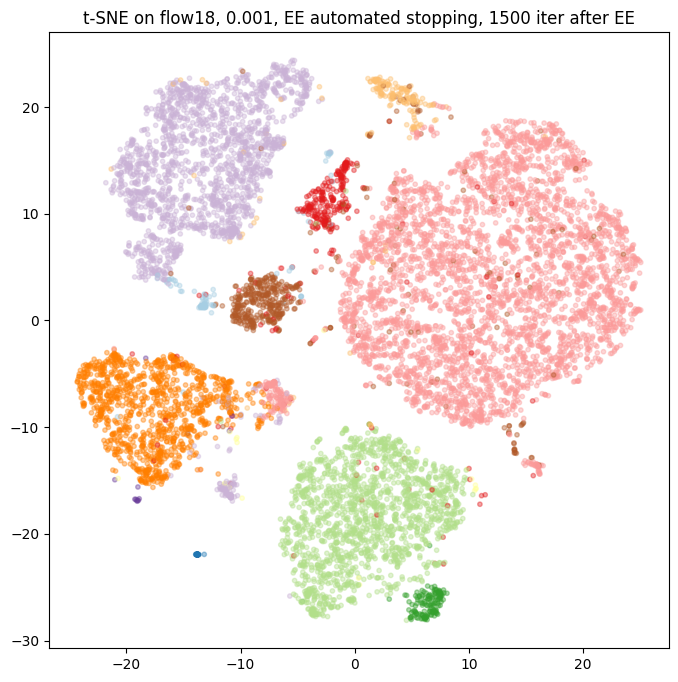

In [77]:
# Final visualization of the t-SNE embedding.
plt.figure(figsize=(8, 8))
plt.scatter(
    flow1000_embedding[:, 0], 
    flow1000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.4
)
plt.title("t-SNE on flow18, 0.001, EE automated stopping, 1500 iter after EE")
plt.show()

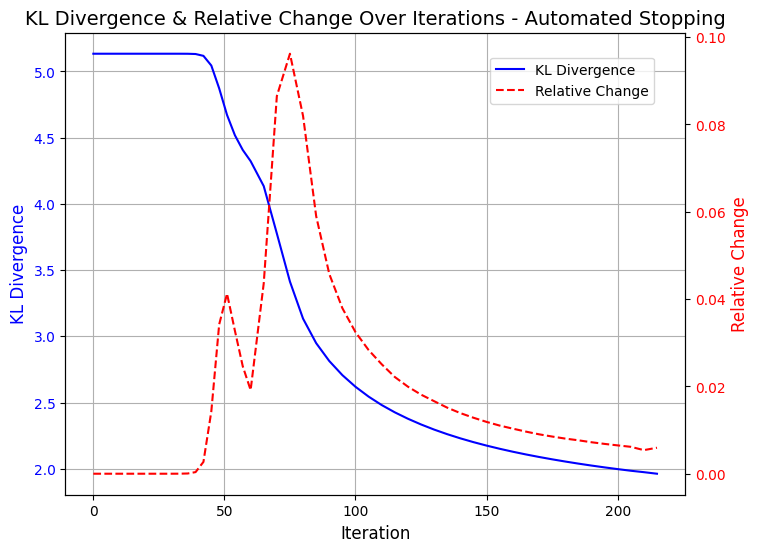

In [78]:
# Extract errors from monitors
EE_errors = np.array([error for _, error in kld_monitor_EE.kl_divergences])
post_EE_errors = np.array([error for _, error in kld_tracker_embed.kl_divergences])

# Generate correctly scaled iteration indices
EE_iterations = np.arange(0, len(EE_errors) * 3, 3)  # Every 3 iterations
last_EE_iteration = EE_iterations[-1] if len(EE_iterations) > 0 else 0  # Get last EE iteration
post_EE_iterations = np.arange(last_EE_iteration + 5, last_EE_iteration + len(post_EE_errors) * 5 + 1, 5)  # Every 5 iterations

# Merge the iteration and error lists
iterations = np.concatenate([EE_iterations, post_EE_iterations])
errors = np.concatenate([EE_errors, post_EE_errors])

# Calculate relative change in KL Divergence
relative_change = np.zeros_like(errors)
relative_change[1:] = (errors[:-1] - errors[1:]) / errors[:-1]  # Relative change calculation

# Plot KL Divergence and Relative Change
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KL Divergence
ax1.plot(iterations, errors, linestyle='-', color='b', label='KL Divergence')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("KL Divergence", fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Secondary y-axis for Relative Change
ax2 = ax1.twinx()
ax2.plot(iterations, relative_change, linestyle='--', color='r', label='Relative Change')
ax2.set_ylabel("Relative Change", fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title("KL Divergence & Relative Change Over Iterations - Automated Stopping", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(0.87, 0.85))

plt.show()


In [109]:
def plot_embedding(data_percentage, neg_grad_method, init, learning_rate):     
    plt.figure(figsize=(6, 6))
    plt.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        c=labels, 
        cmap=plt.colormaps.get_cmap('Paired'), 
        s=10, 
        alpha=0.4
    )
    plt.title(f"opt-SNE on flow18, {100*data_percentage}% of dataset, {neg_grad_method}, {init} initialization, {learning_rate} learning rate")
    plt.show()

In [120]:
from sklearn.neighbors import NearestNeighbors

def compute_1nn_accuracy(Y, labels):
    """
    Computes the 1-Nearest Neighbor (1NN) accuracy of the t-SNE embedding.

    Parameters:
    - Y (numpy array): t-SNE embedding of shape (N, no_dims)
    - labels (numpy array): Ground truth labels of shape (N,)

    Returns:
    - accuracy (float): 1NN classification accuracy
    """
    N = Y.shape[0]  # Number of data points

    # Use Nearest Neighbors to find the closest point
    nn = NearestNeighbors(n_neighbors=2, metric='euclidean')  # Find 2 nearest (1st is itself)
    nn.fit(Y)
    distances, indices = nn.kneighbors(Y)  # Get nearest neighbor indices
    labels = np.array(labels)

    # The 1NN prediction is the label of the nearest neighbor (not itself)
    nearest_neighbor_indices = indices[:, 1]  # Take the second closest (first is itself)
    predicted_labels = labels[nearest_neighbor_indices]

    # Compute accuracy
    accuracy = np.mean(predicted_labels == labels)  # Check how many match

    return accuracy

# Example Usage
# Y: Your t-SNE embedding of shape (N, 2) or (N, 3)
# labels: Ground truth labels of shape (N,)
# accuracy = compute_1nn_accuracy(Y, labels)
# print(f"1NN Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# this runs opt-SNE with FIt-SNE algorithm 
def run_optSNE(neg_grad_method="fft", init="pca", data_percentage=1.0, EE_factor=12, perplexity=50, learning_rate="auto", random_state=12, auto_stop=True): 
    """
        Parameters:
            neg_grad_method (string): Either "bh" for Barnes-Hut or "fft" for FIt-SNE.
            init (string): Either "pca" or "random" 
    """
    
    data_sample = df_filtered.sample(frac=data_percentage).reset_index(drop=True)

    # get features and labels 
    features = data_sample.drop(columns=['class'])  # All columns except 'class'
    labels = data_sample['class']  # Only the 'class' column

    affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=perplexity, 
    n_jobs=-1,
    random_state=random_state,
    verbose=True
    )

    initiali = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True) if init=="random" else openTSNE.initialization.pca(features.to_numpy(), random_state=random_state)


    # step 3: construct TSNEEmbedding object 
    embedding = openTSNE.TSNEEmbedding(
        initiali, 
        affinites, 
        negative_gradient_method=neg_grad_method, 
        random_state=random_state,
        verbose=True
    )

    kld_monitor_EE = KLDRCMonitorEE(record_every=3)
    kld_monitor_EE_noOpt = KLDRCMonitorNoOpt(record_every=3)
    if auto_stop: 
        try:
            embedding = embedding.optimize(
                n_iter=3000, 
                learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
                exaggeration=EE_factor, 
                momentum=0.5, 
                callbacks=kld_monitor_EE, 
                callbacks_every_iters=3, 
                verbose=True
            )
        except Exception as e:
            # OptimizationInterrupt is expected when stopping early.
            print("Early Exaggeration phase stopped early:", e)
    else: 
        embedding = embedding.optimize(
                n_iter=int(2000/4), 
                learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
                exaggeration=EE_factor, 
                momentum=0.5, 
                callbacks=kld_monitor_EE_noOpt, 
                callbacks_every_iters=3, 
                verbose=True
            )
  
    kld_tracker_embed = KLDRCMonitorRun(record_every=5)
    kld_monitor_noOpt = KLDRCMonitorNoOpt(record_every=5)
    if auto_stop: 
        try:
            embedding = embedding.optimize(
                n_iter=10000, 
                learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
                momentum=0.8, 
                callbacks=kld_tracker_embed, 
                callbacks_every_iters=5, 
                verbose=True
            )
        except Exception as e:
            # OptimizationInterrupt is expected when stopping early.
            print("Embedding phase stopped early:", e)
    else: 
        embedding = embedding.optimize(
            n_iter=int(2000/4*3), 
            learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
            momentum=0.8, 
            callbacks=kld_monitor_noOpt, 
            callbacks_every_iters=5, 
            verbose=True
        )

    plot_embedding(data_percentage, neg_grad_method,init, learning_rate)
    final_kld =  kld_tracker_embed.kl_divergences[-1][1] if auto_stop else kld_monitor_noOpt.kl_divergences[-1][1]
    return (embedding, final_kld, labels) 


===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 6.50 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.90 seconds
===> Running optimization with exaggeration=12.00, lr=833.33 for 3000 iterations...
Iteration 6: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 9: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 12: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 15: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 18: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 21: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 24: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 27: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 30: KL Divergence = 5.1303, Relative Change = 0.0000%
Iteration 33: KL Divergence = 5.1302, Relative Change = 0.0001%
Iteration 36: KL Divergence = 5.1302, Relative Change = 0.0008%
Iteration 39: KL

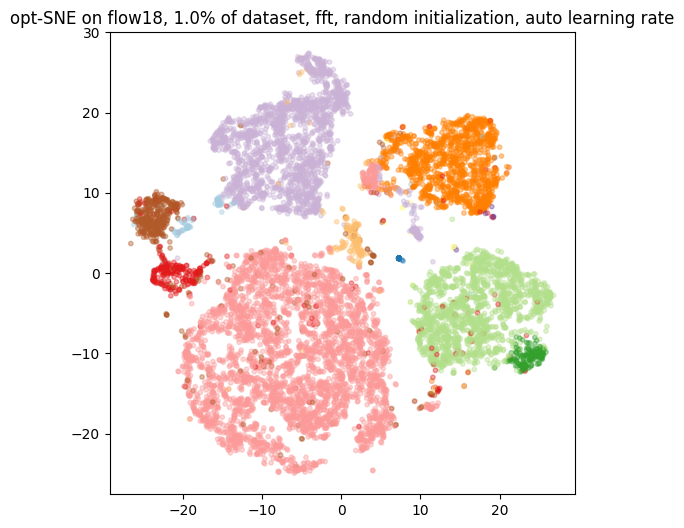

2.001631780549035

In [118]:
embedding, final_kld, labels = run_optSNE("fft", "random", 0.01)
final_kld

In [121]:
compute_1nn_accuracy(embedding, labels)

0.9506

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 7.48 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.07 seconds
===> Running optimization with exaggeration=12.00, lr=833.33 for 3000 iterations...
Iteration 6: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 9: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 12: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 15: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 18: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 21: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 24: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 27: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 30: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 33: KL Divergence = 5.1298, Relative Change = 0.0000%
Iteration 36: KL Divergence = 5.1298, Relative Change = 0.0002%
Iteration 39: KL

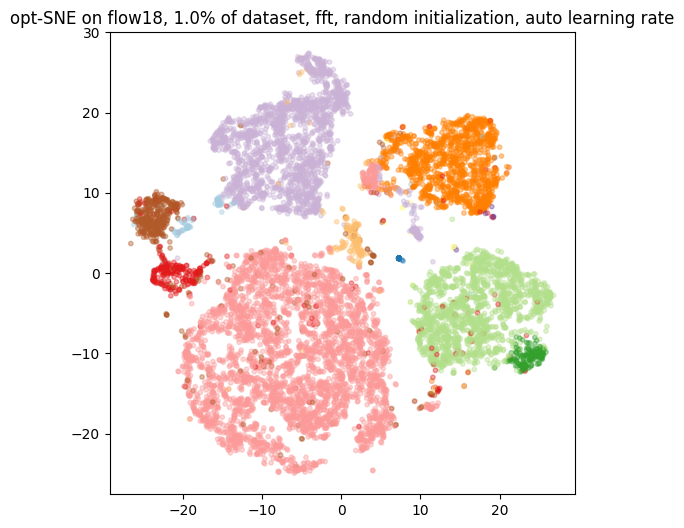

(TSNEEmbedding([[12.70391481, 13.52422573],
                [ 2.92361246, 14.99713394],
                [ 9.36016076,  1.10383626],
                ...,
                [15.3912648 , -6.59163978],
                [ 0.07374953, 17.19663865],
                [15.41571917, -2.19733053]]),
 1.9825554595092338,
 0        7.0
 1        4.0
 2        7.0
 3       11.0
 4        7.0
         ... 
 9995    11.0
 9996     7.0
 9997     7.0
 9998     4.0
 9999     7.0
 Name: class, Length: 10000, dtype: float64)

In [117]:
run_optSNE("fft", "random", 0.01)

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 8.40 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.98 seconds
===> Running optimization with exaggeration=12.00, lr=833.33 for 500 iterations...
Iteration   50, KL divergence 4.9444, 50 iterations in 4.1973 sec
Iteration  100, KL divergence 3.9228, 50 iterations in 2.5853 sec
Iteration  150, KL divergence 3.8235, 50 iterations in 2.8002 sec
Iteration  200, KL divergence 3.7858, 50 iterations in 2.5758 sec
Iteration  250, KL divergence 3.7649, 50 iterations in 2.7968 sec
Iteration  300, KL divergence 3.7518, 50 iterations in 2.9395 sec
Iteration  350, KL divergence 3.7426, 50 iterations in 3.7935 sec
Iteration  400, KL divergence 3.7359, 50 iterations in 2.6501 sec
Iteration  450, KL divergence 3.7307, 50 iterations in 2.5558 sec
Iteration  500, KL divergence 3.7266, 50 iterations in 2.8211 sec
   --> Time elapsed: 29.72 seconds
EE done
===> Running opt

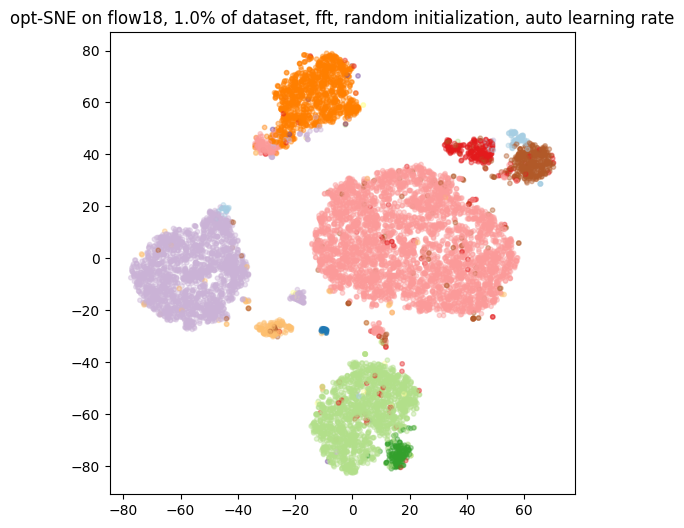

In [103]:
run_optSNE("fft", "random", 0.01, auto_stop= False)

### trying barnes hut algorithm 

In [69]:
# # step 3: construct TSNEEmbedding object 
# bh_embedding = openTSNE.TSNEEmbedding(
#     init, 
#     affinites, 
#     negative_gradient_method='bh', 
#     theta=0.5, 
#     random_state=12,
#     verbose=True
# )

# kld_monitor_EE_bh = KLDRelativeChangeMonitor(record_every=5)

# bh_embedding = bh_embedding.optimize(
#     n_iter=250, 
#     learning_rate=200, 
#     exaggeration=12, 
#     momentum=0.5, 
#     callbacks=kld_monitor_EE, 
#     callbacks_every_iters=5, 
#     verbose=True
# )

# kld_tracker_embed_bh = KLDTracker(record_every=5)
# bh_embedding = bh_embedding.optimize(
#     n_iter=750, 
#     learning_rate=200, 
#     momentum=0.8, 
#     callbacks=kld_tracker_embed, 
#     callbacks_every_iters=5, 
#     verbose=True
# )

In [70]:
# # Final visualization of the t-SNE embedding.
# plt.figure(figsize=(8, 8))
# plt.scatter(
#     bh_embedding[:, 0], 
#     bh_embedding[:, 1], 
#     c=labels, 
#     cmap=plt.colormaps.get_cmap('Paired'), 
#     s=10, 
#     alpha=0.4
# )
# plt.title("t-SNE on flow18, EE automated stopping, 1500 iter after EE")
# plt.show()

In [71]:
# adjusted_divergences = [(iterations + 735, errors) for (iterations, errors) in kld_tracker_embed.kl_divergences]
# iterations, errors = zip(*(kld_monitor_EE.kl_divergences + adjusted_divergences))

# # Calculate relative change in KL Divergence
# errors = np.array(errors)
# relative_change = np.zeros_like(errors)
# relative_change[1:] = (errors[:-1] - errors[1:]) / errors[:-1]  # Relative change calculation

# # Plot KL Divergence and Relative Change
# fig, ax1 = plt.subplots(figsize=(8, 6))

# # Plot KL Divergence
# ax1.plot(iterations, errors, linestyle='-', color='b', label='KL Divergence')
# ax1.set_xlabel("Iteration", fontsize=12)
# ax1.set_ylabel("KL Divergence", fontsize=12, color='b')
# ax1.tick_params(axis='y', labelcolor='b')
# ax1.grid(True)

# # Secondary y-axis for Relative Change
# ax2 = ax1.twinx()
# ax2.plot(iterations, relative_change, linestyle='--', color='r', label='Relative Change')
# ax2.set_ylabel("Relative Change", fontsize=12, color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# # Title and legend
# plt.title("KL Divergence & Relative Change Over Iterations - 1500 iter after EE, automated stopping", fontsize=14)
# fig.legend(loc="upper right", bbox_to_anchor=(0.87, 0.85))

# plt.show()